In [1]:
import torch

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

/home/rkn/.local/share/virtualenvs/lab-work-gFKfzxI5/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


device(type='cuda')

In [2]:
from transformers import ViTFeatureExtractor

feature_extractor = ViTFeatureExtractor.from_pretrained('google/vit-base-patch16-224-in21k')

/home/rkn/.local/share/virtualenvs/lab-work-gFKfzxI5/lib/python3.10/site-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(


In [3]:
import os
import numpy as np
import pandas as pd
import torch
import torchvision
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image

def csv2labelnp(csv_file):
    label_df = pd.read_csv(csv_file, header=None)
    return label_df.loc[:,2:].to_numpy() / 10

def pil_loader(path):
    with open(path, 'rb') as f:
        img = Image.open(f)
        return img.convert('RGB')

class FERPlusDataset(Dataset):
    def __init__(self, root, mode, threshold=0.3, transform=None):
        self.labels = csv2labelnp(os.path.join(root, 'label.csv'))
        self.samples = [os.path.join(root, img_name) for img_name in sorted(os.listdir(root))[:-1]]
        self.mode = mode
        self.threshold = threshold
        self.transform = transform
    
    def __getitem__(self, idx):
        img = pil_loader(self.samples[idx])
        if self.transform:
            img = self.transform(img)
        target = self.labels[idx]
        if self.mode == 'majority':
            target = np.argmax(target)
            target = torch.tensor(target)
        elif self.mode == 'multi-label':
            target = (target > self.threshold).astype(int)
            target = torch.from_numpy(target)
        else:
            target = torch.from_numpy(target)
        return img, target
    
    def __len__(self):
        return len(self.samples)

In [4]:
from torchvision.transforms import (Compose,
                                    Normalize,
                                    Resize,
                                    ToTensor,
                                    RandomAffine)

normalize = Normalize(mean=sum(feature_extractor.image_mean) / len(feature_extractor.image_mean),
                      std=sum(feature_extractor.image_std) / len(feature_extractor.image_std))

train_transform = Compose([RandomAffine(30),
                           Resize(tuple(feature_extractor.size.values())),
                           ToTensor()])

val_test_transform = Compose([Resize(tuple(feature_extractor.size.values())),
                              ToTensor()])

mode = 'majority'

train_dataset = FERPlusDataset('FERPlus/data/FER2013Train',
                               mode,
                               transform=train_transform)
val_dataset = FERPlusDataset('FERPlus/data/FER2013Valid',
                             mode,
                             transform=val_test_transform)
test_dataset = FERPlusDataset('FERPlus/data/FER2013Test',
                              mode,
                              transform=val_test_transform)

print('train:', len(train_dataset))
print('val:', len(val_dataset))
print('test:', len(test_dataset))

train: 28558
val: 3579
test: 3573


In [5]:
def collate_fn(examples):
    imgs, labels = zip(*examples)
    pixel_values = torch.stack(imgs)
    labels = torch.stack(labels)
    return {'pixel_values': pixel_values, 'labels': labels}

In [6]:
train_dataloader = DataLoader(train_dataset, collate_fn=collate_fn, batch_size=4)

batch = next(iter(train_dataloader))
for k,v in batch.items():
  if isinstance(v, torch.Tensor):
    print(k, v.shape)

pixel_values torch.Size([4, 3, 224, 224])
labels torch.Size([4])


In [7]:
id2label = {
    0: 'neutral',
    1: 'happiness',
    2: 'surprise',
    3: 'sadness',
    4: 'anger',
    5: 'disgust',
    6: 'fear',
    7: 'contempt',
    8: 'unknown',
    9: 'NF'
}
label2id = {v:k for k,v in id2label.items()}

label2id

{'neutral': 0,
 'happiness': 1,
 'surprise': 2,
 'sadness': 3,
 'anger': 4,
 'disgust': 5,
 'fear': 6,
 'contempt': 7,
 'unknown': 8,
 'NF': 9}

In [8]:
from transformers import ViTForImageClassification

model = ViTForImageClassification.from_pretrained('google/vit-base-patch16-224-in21k',
                                                  num_labels=len(label2id),
                                                  label2id=label2id,
                                                  id2label=id2label)

Some weights of the model checkpoint at google/vit-base-patch16-224-in21k were not used when initializing ViTForImageClassification: ['pooler.dense.bias', 'pooler.dense.weight']
- This IS expected if you are initializing ViTForImageClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ViTForImageClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [9]:
from transformers import TrainingArguments, Trainer

metric_name = "accuracy"

args = TrainingArguments(
    f"fer-majority-vit",
    save_strategy="epoch",
    evaluation_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=8,
    num_train_epochs=50,
    weight_decay=0.01,
    load_best_model_at_end=True,
    metric_for_best_model=metric_name,
    logging_dir='logs',
    remove_unused_columns=False,
)

In [10]:
from datasets import load_metric
import numpy as np

metric = load_metric("accuracy")

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return metric.compute(predictions=predictions, references=labels)

/tmp/ipykernel_499528/1052707893.py:4: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  metric = load_metric("accuracy")


In [11]:
label_ratio = torch.tensor([0]*len(id2label))
for _, label in train_dataset:
    label = label.tolist()
    label_ratio[label] += 1
label_ratio = label_ratio / len(train_dataset)
weight = (1 / label_ratio).clone().to(device, torch.float32)
log_weight = (-torch.log(label_ratio)).clone().to(device, torch.float32)
log_weight[-2] = log_weight[-1] = 1
print(weight)
print(log_weight)

tensor([2.7740e+00, 3.7946e+00, 8.0287e+00, 8.0901e+00, 1.1595e+01, 1.4952e+02,
        4.3600e+01, 1.6999e+02, 1.6701e+02, 1.4279e+04], device='cuda:0')
tensor([1.0203, 1.3336, 2.0830, 2.0906, 2.4506, 5.0074, 3.7751, 5.1357, 1.0000,
        1.0000], device='cuda:0')


In [12]:
import torch.nn as nn
from torch.utils.data.sampler import WeightedRandomSampler

class WeightedLossTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False):
        labels = inputs.get('labels')
        outputs = model(**inputs)
        logits = outputs.get('logits')
        loss_fct = nn.CrossEntropyLoss(weight=log_weight)
        loss = loss_fct(logits.view(-1, self.model.config.num_labels), labels.view(-1))
        return (loss, outputs) if return_outputs else loss

class WeightedRandomSamplerTrainer(Trainer):
    def get_train_dataloader(self) -> DataLoader:
        if self.train_dataset is None:
            raise ValueError("Trainer: training requires a train_dataset.")

        train_dataset = self.train_dataset
        data_collator = self.data_collator
        return DataLoader(
            train_dataset,
            batch_size=self._train_batch_size,
            sampler=WeightedRandomSampler(weights=weight, num_samples=len(train_dataset)),
            collate_fn=data_collator,
            drop_last=self.args.dataloader_drop_last,
            num_workers=self.args.dataloader_num_workers,
            pin_memory=self.args.dataloader_pin_memory,
        )

In [13]:
trainer = WeightedLossTrainer(
# trainer = WeightedRandomSamplerTrainer(
    model,
    args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    data_collator=collate_fn,
    compute_metrics=compute_metrics,
    tokenizer=feature_extractor,
)

In [14]:
trainer.train()

/home/rkn/.local/share/virtualenvs/lab-work-gFKfzxI5/lib/python3.10/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 28558
  Num Epochs = 50
  Instantaneous batch size per device = 32
  Total train batch size (w. parallel, distributed & accumulation) = 32
  Gradient Accumulation steps = 1
  Total optimization steps = 44650
  Number of trainable parameters = 85806346
  1%|          | 500/44650 [02:34<3:46:39,  3.25it/s]

{'loss': 1.3614, 'learning_rate': 1.9776035834266518e-05, 'epoch': 0.56}


  2%|▏         | 893/44650 [04:33<3:08:00,  3.88it/s]***** Running Evaluation *****
  Num examples = 3579
  Batch size = 8
                                                     
  2%|▏         | 893/44650 [04:47<3:08:00,  3.88it/s]Saving model checkpoint to fer-majority-vit/checkpoint-893
Configuration saved in fer-majority-vit/checkpoint-893/config.json


{'eval_loss': 0.8583593368530273, 'eval_accuracy': 0.7708857222687902, 'eval_runtime': 13.462, 'eval_samples_per_second': 265.86, 'eval_steps_per_second': 33.279, 'epoch': 1.0}


Model weights saved in fer-majority-vit/checkpoint-893/pytorch_model.bin
Image processor saved in fer-majority-vit/checkpoint-893/preprocessor_config.json
  2%|▏         | 1000/44650 [05:26<3:38:54,  3.32it/s]

{'loss': 0.9647, 'learning_rate': 1.955207166853304e-05, 'epoch': 1.12}


  3%|▎         | 1500/44650 [07:58<3:40:54,  3.26it/s]

{'loss': 0.8346, 'learning_rate': 1.9328107502799555e-05, 'epoch': 1.68}


  4%|▍         | 1786/44650 [09:26<3:06:23,  3.83it/s]***** Running Evaluation *****
  Num examples = 3579
  Batch size = 8
                                                      
  4%|▍         | 1786/44650 [09:39<3:06:23,  3.83it/s]Saving model checkpoint to fer-majority-vit/checkpoint-1786
Configuration saved in fer-majority-vit/checkpoint-1786/config.json


{'eval_loss': 0.7181516885757446, 'eval_accuracy': 0.8024587873707739, 'eval_runtime': 13.6143, 'eval_samples_per_second': 262.885, 'eval_steps_per_second': 32.907, 'epoch': 2.0}


Model weights saved in fer-majority-vit/checkpoint-1786/pytorch_model.bin
Image processor saved in fer-majority-vit/checkpoint-1786/preprocessor_config.json
  4%|▍         | 2000/44650 [10:51<3:37:05,  3.27it/s] 

{'loss': 0.7485, 'learning_rate': 1.910414333706607e-05, 'epoch': 2.24}


  6%|▌         | 2500/44650 [13:26<3:37:43,  3.23it/s]

{'loss': 0.6858, 'learning_rate': 1.888017917133259e-05, 'epoch': 2.8}


  6%|▌         | 2679/44650 [14:21<3:04:26,  3.79it/s]***** Running Evaluation *****
  Num examples = 3579
  Batch size = 8
                                                      
  6%|▌         | 2679/44650 [14:35<3:04:26,  3.79it/s]Saving model checkpoint to fer-majority-vit/checkpoint-2679
Configuration saved in fer-majority-vit/checkpoint-2679/config.json


{'eval_loss': 0.6545335650444031, 'eval_accuracy': 0.8178262084381112, 'eval_runtime': 13.7758, 'eval_samples_per_second': 259.803, 'eval_steps_per_second': 32.521, 'epoch': 3.0}


Model weights saved in fer-majority-vit/checkpoint-2679/pytorch_model.bin
Image processor saved in fer-majority-vit/checkpoint-2679/preprocessor_config.json
  7%|▋         | 3000/44650 [16:20<3:35:12,  3.23it/s] 

{'loss': 0.6352, 'learning_rate': 1.8656215005599105e-05, 'epoch': 3.36}


  8%|▊         | 3500/44650 [18:54<3:30:59,  3.25it/s]

{'loss': 0.6126, 'learning_rate': 1.8432250839865622e-05, 'epoch': 3.92}


  8%|▊         | 3572/44650 [19:16<2:59:01,  3.82it/s]***** Running Evaluation *****
  Num examples = 3579
  Batch size = 8
                                                      
  8%|▊         | 3572/44650 [19:29<2:59:01,  3.82it/s]Saving model checkpoint to fer-majority-vit/checkpoint-3572
Configuration saved in fer-majority-vit/checkpoint-3572/config.json


{'eval_loss': 0.6458553075790405, 'eval_accuracy': 0.8239731768650461, 'eval_runtime': 13.6248, 'eval_samples_per_second': 262.682, 'eval_steps_per_second': 32.881, 'epoch': 4.0}


Model weights saved in fer-majority-vit/checkpoint-3572/pytorch_model.bin
Image processor saved in fer-majority-vit/checkpoint-3572/preprocessor_config.json
  9%|▉         | 4000/44650 [21:47<3:28:11,  3.25it/s] 

{'loss': 0.567, 'learning_rate': 1.8208286674132142e-05, 'epoch': 4.48}


 10%|█         | 4465/44650 [24:09<2:53:01,  3.87it/s]***** Running Evaluation *****
  Num examples = 3579
  Batch size = 8
                                                      
 10%|█         | 4465/44650 [24:23<2:53:01,  3.87it/s]Saving model checkpoint to fer-majority-vit/checkpoint-4465
Configuration saved in fer-majority-vit/checkpoint-4465/config.json


{'eval_loss': 0.5860163569450378, 'eval_accuracy': 0.818105616093881, 'eval_runtime': 13.4616, 'eval_samples_per_second': 265.867, 'eval_steps_per_second': 33.28, 'epoch': 5.0}


Model weights saved in fer-majority-vit/checkpoint-4465/pytorch_model.bin
Image processor saved in fer-majority-vit/checkpoint-4465/preprocessor_config.json
 10%|█         | 4500/44650 [24:40<3:22:02,  3.31it/s] 

{'loss': 0.5321, 'learning_rate': 1.798432250839866e-05, 'epoch': 5.04}


 11%|█         | 5000/44650 [27:12<3:21:09,  3.29it/s]

{'loss': 0.4995, 'learning_rate': 1.7760358342665175e-05, 'epoch': 5.6}


 12%|█▏        | 5358/44650 [29:01<2:50:44,  3.84it/s]***** Running Evaluation *****
  Num examples = 3579
  Batch size = 8
                                                      
 12%|█▏        | 5358/44650 [29:15<2:50:44,  3.84it/s]Saving model checkpoint to fer-majority-vit/checkpoint-5358
Configuration saved in fer-majority-vit/checkpoint-5358/config.json


{'eval_loss': 0.5676377415657043, 'eval_accuracy': 0.8382229673093042, 'eval_runtime': 13.6693, 'eval_samples_per_second': 261.828, 'eval_steps_per_second': 32.774, 'epoch': 6.0}


Model weights saved in fer-majority-vit/checkpoint-5358/pytorch_model.bin
Image processor saved in fer-majority-vit/checkpoint-5358/preprocessor_config.json
 12%|█▏        | 5500/44650 [30:06<3:20:42,  3.25it/s] 

{'loss': 0.4825, 'learning_rate': 1.7536394176931692e-05, 'epoch': 6.16}


 13%|█▎        | 6000/44650 [32:40<3:18:51,  3.24it/s]

{'loss': 0.4405, 'learning_rate': 1.731243001119821e-05, 'epoch': 6.72}


 14%|█▍        | 6251/44650 [33:58<2:46:49,  3.84it/s]***** Running Evaluation *****
  Num examples = 3579
  Batch size = 8
                                                      
 14%|█▍        | 6251/44650 [34:11<2:46:49,  3.84it/s]Saving model checkpoint to fer-majority-vit/checkpoint-6251
Configuration saved in fer-majority-vit/checkpoint-6251/config.json


{'eval_loss': 0.5985879302024841, 'eval_accuracy': 0.8390611902766136, 'eval_runtime': 13.6123, 'eval_samples_per_second': 262.925, 'eval_steps_per_second': 32.912, 'epoch': 7.0}


Model weights saved in fer-majority-vit/checkpoint-6251/pytorch_model.bin
Image processor saved in fer-majority-vit/checkpoint-6251/preprocessor_config.json
 15%|█▍        | 6500/44650 [35:35<3:15:31,  3.25it/s] 

{'loss': 0.4327, 'learning_rate': 1.708846584546473e-05, 'epoch': 7.28}


 16%|█▌        | 7000/44650 [38:09<3:15:36,  3.21it/s]

{'loss': 0.409, 'learning_rate': 1.6864501679731245e-05, 'epoch': 7.84}


 16%|█▌        | 7144/44650 [38:53<2:41:55,  3.86it/s]***** Running Evaluation *****
  Num examples = 3579
  Batch size = 8
                                                      
 16%|█▌        | 7144/44650 [39:06<2:41:55,  3.86it/s]Saving model checkpoint to fer-majority-vit/checkpoint-7144
Configuration saved in fer-majority-vit/checkpoint-7144/config.json


{'eval_loss': 0.5847888588905334, 'eval_accuracy': 0.8242525845208158, 'eval_runtime': 13.7252, 'eval_samples_per_second': 260.762, 'eval_steps_per_second': 32.641, 'epoch': 8.0}


Model weights saved in fer-majority-vit/checkpoint-7144/pytorch_model.bin
Image processor saved in fer-majority-vit/checkpoint-7144/preprocessor_config.json
 17%|█▋        | 7500/44650 [41:04<3:08:47,  3.28it/s] 

{'loss': 0.3743, 'learning_rate': 1.6640537513997762e-05, 'epoch': 8.4}


 18%|█▊        | 8000/44650 [43:36<3:05:18,  3.30it/s]

{'loss': 0.3645, 'learning_rate': 1.641657334826428e-05, 'epoch': 8.96}


 18%|█▊        | 8037/44650 [43:47<2:39:26,  3.83it/s]***** Running Evaluation *****
  Num examples = 3579
  Batch size = 8
                                                      
 18%|█▊        | 8037/44650 [44:01<2:39:26,  3.83it/s]Saving model checkpoint to fer-majority-vit/checkpoint-8037
Configuration saved in fer-majority-vit/checkpoint-8037/config.json


{'eval_loss': 0.5817400813102722, 'eval_accuracy': 0.8206202849958089, 'eval_runtime': 13.4693, 'eval_samples_per_second': 265.715, 'eval_steps_per_second': 33.261, 'epoch': 9.0}


Model weights saved in fer-majority-vit/checkpoint-8037/pytorch_model.bin
Image processor saved in fer-majority-vit/checkpoint-8037/preprocessor_config.json
 19%|█▉        | 8500/44650 [46:28<3:04:39,  3.26it/s] 

{'loss': 0.3217, 'learning_rate': 1.6192609182530795e-05, 'epoch': 9.52}


 20%|██        | 8930/44650 [48:41<2:36:33,  3.80it/s]***** Running Evaluation *****
  Num examples = 3579
  Batch size = 8
                                                      
 20%|██        | 8930/44650 [48:54<2:36:33,  3.80it/s]Saving model checkpoint to fer-majority-vit/checkpoint-8930
Configuration saved in fer-majority-vit/checkpoint-8930/config.json


{'eval_loss': 0.6104234457015991, 'eval_accuracy': 0.829002514668902, 'eval_runtime': 13.769, 'eval_samples_per_second': 259.933, 'eval_steps_per_second': 32.537, 'epoch': 10.0}


Model weights saved in fer-majority-vit/checkpoint-8930/pytorch_model.bin
Image processor saved in fer-majority-vit/checkpoint-8930/preprocessor_config.json
 20%|██        | 9000/44650 [49:23<3:03:42,  3.23it/s] 

{'loss': 0.3321, 'learning_rate': 1.5968645016797312e-05, 'epoch': 10.08}


 21%|██▏       | 9500/44650 [51:57<2:58:47,  3.28it/s]

{'loss': 0.2867, 'learning_rate': 1.5744680851063832e-05, 'epoch': 10.64}


 22%|██▏       | 9823/44650 [53:37<2:32:04,  3.82it/s]***** Running Evaluation *****
  Num examples = 3579
  Batch size = 8
                                                      
 22%|██▏       | 9823/44650 [53:50<2:32:04,  3.82it/s]Saving model checkpoint to fer-majority-vit/checkpoint-9823
Configuration saved in fer-majority-vit/checkpoint-9823/config.json


{'eval_loss': 0.6295308470726013, 'eval_accuracy': 0.8371053366862252, 'eval_runtime': 13.6221, 'eval_samples_per_second': 262.736, 'eval_steps_per_second': 32.888, 'epoch': 11.0}


Model weights saved in fer-majority-vit/checkpoint-9823/pytorch_model.bin
Image processor saved in fer-majority-vit/checkpoint-9823/preprocessor_config.json
 22%|██▏       | 10000/44650 [54:52<2:57:25,  3.25it/s]

{'loss': 0.2793, 'learning_rate': 1.552071668533035e-05, 'epoch': 11.2}


 24%|██▎       | 10500/44650 [57:26<2:55:12,  3.25it/s]

{'loss': 0.2621, 'learning_rate': 1.5296752519596865e-05, 'epoch': 11.76}


 24%|██▍       | 10716/44650 [58:33<2:25:36,  3.88it/s]***** Running Evaluation *****
  Num examples = 3579
  Batch size = 8
                                                       
 24%|██▍       | 10716/44650 [58:46<2:25:36,  3.88it/s]Saving model checkpoint to fer-majority-vit/checkpoint-10716
Configuration saved in fer-majority-vit/checkpoint-10716/config.json


{'eval_loss': 0.6248673796653748, 'eval_accuracy': 0.8323554065381391, 'eval_runtime': 13.4466, 'eval_samples_per_second': 266.165, 'eval_steps_per_second': 33.317, 'epoch': 12.0}


Model weights saved in fer-majority-vit/checkpoint-10716/pytorch_model.bin
Image processor saved in fer-majority-vit/checkpoint-10716/preprocessor_config.json
 25%|██▍       | 11000/44650 [1:00:18<2:49:47,  3.30it/s]

{'loss': 0.2597, 'learning_rate': 1.5072788353863384e-05, 'epoch': 12.32}


 26%|██▌       | 11500/44650 [1:02:51<2:47:46,  3.29it/s]

{'loss': 0.2424, 'learning_rate': 1.48488241881299e-05, 'epoch': 12.88}


 26%|██▌       | 11609/44650 [1:03:24<2:22:13,  3.87it/s]***** Running Evaluation *****
  Num examples = 3579
  Batch size = 8
                                                         
 26%|██▌       | 11609/44650 [1:03:37<2:22:13,  3.87it/s]Saving model checkpoint to fer-majority-vit/checkpoint-11609
Configuration saved in fer-majority-vit/checkpoint-11609/config.json


{'eval_loss': 0.6575868725776672, 'eval_accuracy': 0.8270466610785135, 'eval_runtime': 13.6049, 'eval_samples_per_second': 263.067, 'eval_steps_per_second': 32.929, 'epoch': 13.0}


Model weights saved in fer-majority-vit/checkpoint-11609/pytorch_model.bin
Image processor saved in fer-majority-vit/checkpoint-11609/preprocessor_config.json
 27%|██▋       | 12000/44650 [1:05:44<2:49:06,  3.22it/s] 

{'loss': 0.2144, 'learning_rate': 1.4624860022396419e-05, 'epoch': 13.44}


 28%|██▊       | 12500/44650 [1:08:18<2:46:58,  3.21it/s]

{'loss': 0.2333, 'learning_rate': 1.4400895856662935e-05, 'epoch': 14.0}


 28%|██▊       | 12502/44650 [1:08:19<2:21:30,  3.79it/s]***** Running Evaluation *****
  Num examples = 3579
  Batch size = 8
                                                         
 28%|██▊       | 12502/44650 [1:08:33<2:21:30,  3.79it/s]Saving model checkpoint to fer-majority-vit/checkpoint-12502
Configuration saved in fer-majority-vit/checkpoint-12502/config.json


{'eval_loss': 0.6815602779388428, 'eval_accuracy': 0.833752444816988, 'eval_runtime': 13.8006, 'eval_samples_per_second': 259.337, 'eval_steps_per_second': 32.462, 'epoch': 14.0}


Model weights saved in fer-majority-vit/checkpoint-12502/pytorch_model.bin
Image processor saved in fer-majority-vit/checkpoint-12502/preprocessor_config.json
 29%|██▉       | 13000/44650 [1:11:13<2:42:22,  3.25it/s] 

{'loss': 0.1967, 'learning_rate': 1.4176931690929452e-05, 'epoch': 14.56}


 30%|███       | 13395/44650 [1:13:14<2:15:48,  3.84it/s]***** Running Evaluation *****
  Num examples = 3579
  Batch size = 8
                                                         
 30%|███       | 13395/44650 [1:13:28<2:15:48,  3.84it/s]Saving model checkpoint to fer-majority-vit/checkpoint-13395
Configuration saved in fer-majority-vit/checkpoint-13395/config.json


{'eval_loss': 0.7078720927238464, 'eval_accuracy': 0.8390611902766136, 'eval_runtime': 13.6064, 'eval_samples_per_second': 263.039, 'eval_steps_per_second': 32.926, 'epoch': 15.0}


Model weights saved in fer-majority-vit/checkpoint-13395/pytorch_model.bin
Image processor saved in fer-majority-vit/checkpoint-13395/preprocessor_config.json
 30%|███       | 13500/44650 [1:14:06<2:39:41,  3.25it/s] 

{'loss': 0.1948, 'learning_rate': 1.395296752519597e-05, 'epoch': 15.12}


 31%|███▏      | 14000/44650 [1:16:40<2:34:31,  3.31it/s]

{'loss': 0.1817, 'learning_rate': 1.3729003359462487e-05, 'epoch': 15.68}


 32%|███▏      | 14288/44650 [1:18:07<2:09:55,  3.89it/s]***** Running Evaluation *****
  Num examples = 3579
  Batch size = 8
                                                         
 32%|███▏      | 14288/44650 [1:18:21<2:09:55,  3.89it/s]Saving model checkpoint to fer-majority-vit/checkpoint-14288
Configuration saved in fer-majority-vit/checkpoint-14288/config.json


{'eval_loss': 0.7072768211364746, 'eval_accuracy': 0.8331936295054484, 'eval_runtime': 13.5169, 'eval_samples_per_second': 264.779, 'eval_steps_per_second': 33.144, 'epoch': 16.0}


Model weights saved in fer-majority-vit/checkpoint-14288/pytorch_model.bin
Image processor saved in fer-majority-vit/checkpoint-14288/preprocessor_config.json
 32%|███▏      | 14500/44650 [1:19:32<2:32:17,  3.30it/s] 

{'loss': 0.1812, 'learning_rate': 1.3505039193729004e-05, 'epoch': 16.24}


 34%|███▎      | 15000/44650 [1:22:04<2:32:28,  3.24it/s]

{'loss': 0.174, 'learning_rate': 1.3281075027995522e-05, 'epoch': 16.8}


 34%|███▍      | 15181/44650 [1:23:00<2:09:05,  3.80it/s]***** Running Evaluation *****
  Num examples = 3579
  Batch size = 8
                                                         
 34%|███▍      | 15181/44650 [1:23:14<2:09:05,  3.80it/s]Saving model checkpoint to fer-majority-vit/checkpoint-15181
Configuration saved in fer-majority-vit/checkpoint-15181/config.json


{'eval_loss': 0.7803291082382202, 'eval_accuracy': 0.8320759988823694, 'eval_runtime': 13.7074, 'eval_samples_per_second': 261.1, 'eval_steps_per_second': 32.683, 'epoch': 17.0}


Model weights saved in fer-majority-vit/checkpoint-15181/pytorch_model.bin
Image processor saved in fer-majority-vit/checkpoint-15181/preprocessor_config.json
 35%|███▍      | 15500/44650 [1:24:59<2:30:34,  3.23it/s] 

{'loss': 0.1541, 'learning_rate': 1.3057110862262039e-05, 'epoch': 17.36}


 36%|███▌      | 16000/44650 [1:27:34<2:27:56,  3.23it/s]

{'loss': 0.1588, 'learning_rate': 1.2833146696528555e-05, 'epoch': 17.92}


 36%|███▌      | 16074/44650 [1:27:56<2:04:39,  3.82it/s]***** Running Evaluation *****
  Num examples = 3579
  Batch size = 8
                                                         
 36%|███▌      | 16074/44650 [1:28:10<2:04:39,  3.82it/s]Saving model checkpoint to fer-majority-vit/checkpoint-16074
Configuration saved in fer-majority-vit/checkpoint-16074/config.json


{'eval_loss': 0.7831529974937439, 'eval_accuracy': 0.8398994132439229, 'eval_runtime': 13.704, 'eval_samples_per_second': 261.164, 'eval_steps_per_second': 32.691, 'epoch': 18.0}


Model weights saved in fer-majority-vit/checkpoint-16074/pytorch_model.bin
Image processor saved in fer-majority-vit/checkpoint-16074/preprocessor_config.json
 37%|███▋      | 16500/44650 [1:30:28<2:24:38,  3.24it/s] 

{'loss': 0.1445, 'learning_rate': 1.2609182530795074e-05, 'epoch': 18.48}


 38%|███▊      | 16967/44650 [1:32:52<2:00:24,  3.83it/s]***** Running Evaluation *****
  Num examples = 3579
  Batch size = 8
                                                         
 38%|███▊      | 16967/44650 [1:33:05<2:00:24,  3.83it/s]Saving model checkpoint to fer-majority-vit/checkpoint-16967
Configuration saved in fer-majority-vit/checkpoint-16967/config.json


{'eval_loss': 0.8927794694900513, 'eval_accuracy': 0.8398994132439229, 'eval_runtime': 13.5371, 'eval_samples_per_second': 264.384, 'eval_steps_per_second': 33.094, 'epoch': 19.0}


Model weights saved in fer-majority-vit/checkpoint-16967/pytorch_model.bin
Image processor saved in fer-majority-vit/checkpoint-16967/preprocessor_config.json
 38%|███▊      | 17000/44650 [1:33:22<2:19:05,  3.31it/s] 

{'loss': 0.1456, 'learning_rate': 1.238521836506159e-05, 'epoch': 19.04}


 39%|███▉      | 17500/44650 [1:35:54<2:17:53,  3.28it/s]

{'loss': 0.1296, 'learning_rate': 1.2161254199328107e-05, 'epoch': 19.6}


 40%|████      | 17860/44650 [1:37:43<1:55:02,  3.88it/s]***** Running Evaluation *****
  Num examples = 3579
  Batch size = 8
                                                         
 40%|████      | 17860/44650 [1:37:57<1:55:02,  3.88it/s]Saving model checkpoint to fer-majority-vit/checkpoint-17860
Configuration saved in fer-majority-vit/checkpoint-17860/config.json


{'eval_loss': 0.8498286008834839, 'eval_accuracy': 0.8348700754400671, 'eval_runtime': 13.4628, 'eval_samples_per_second': 265.843, 'eval_steps_per_second': 33.277, 'epoch': 20.0}


Model weights saved in fer-majority-vit/checkpoint-17860/pytorch_model.bin
Image processor saved in fer-majority-vit/checkpoint-17860/preprocessor_config.json
 40%|████      | 18000/44650 [1:38:46<2:15:11,  3.29it/s] 

{'loss': 0.1377, 'learning_rate': 1.1937290033594627e-05, 'epoch': 20.16}


 41%|████▏     | 18500/44650 [1:41:19<2:13:31,  3.26it/s]

{'loss': 0.1311, 'learning_rate': 1.1713325867861142e-05, 'epoch': 20.72}


 42%|████▏     | 18753/44650 [1:42:37<1:53:19,  3.81it/s]***** Running Evaluation *****
  Num examples = 3579
  Batch size = 8
                                                         
 42%|████▏     | 18753/44650 [1:42:51<1:53:19,  3.81it/s]Saving model checkpoint to fer-majority-vit/checkpoint-18753
Configuration saved in fer-majority-vit/checkpoint-18753/config.json


{'eval_loss': 0.8655171990394592, 'eval_accuracy': 0.837384744341995, 'eval_runtime': 13.7025, 'eval_samples_per_second': 261.192, 'eval_steps_per_second': 32.695, 'epoch': 21.0}


Model weights saved in fer-majority-vit/checkpoint-18753/pytorch_model.bin
Image processor saved in fer-majority-vit/checkpoint-18753/preprocessor_config.json
 43%|████▎     | 19000/44650 [1:44:15<2:12:08,  3.24it/s] 

{'loss': 0.1277, 'learning_rate': 1.1489361702127662e-05, 'epoch': 21.28}


 44%|████▎     | 19500/44650 [1:46:49<2:09:00,  3.25it/s]

{'loss': 0.127, 'learning_rate': 1.1265397536394179e-05, 'epoch': 21.84}


 44%|████▍     | 19646/44650 [1:47:34<1:48:31,  3.84it/s]***** Running Evaluation *****
  Num examples = 3579
  Batch size = 8
                                                         
 44%|████▍     | 19646/44650 [1:47:47<1:48:31,  3.84it/s]Saving model checkpoint to fer-majority-vit/checkpoint-19646
Configuration saved in fer-majority-vit/checkpoint-19646/config.json


{'eval_loss': 0.8327947854995728, 'eval_accuracy': 0.8359877060631461, 'eval_runtime': 13.5778, 'eval_samples_per_second': 263.593, 'eval_steps_per_second': 32.995, 'epoch': 22.0}


Model weights saved in fer-majority-vit/checkpoint-19646/pytorch_model.bin
Image processor saved in fer-majority-vit/checkpoint-19646/preprocessor_config.json
 45%|████▍     | 20000/44650 [1:49:43<2:06:34,  3.25it/s] 

{'loss': 0.1116, 'learning_rate': 1.1041433370660695e-05, 'epoch': 22.4}


 46%|████▌     | 20500/44650 [1:52:17<2:03:23,  3.26it/s]

{'loss': 0.1237, 'learning_rate': 1.0817469204927214e-05, 'epoch': 22.96}


 46%|████▌     | 20539/44650 [1:52:29<1:44:34,  3.84it/s]***** Running Evaluation *****
  Num examples = 3579
  Batch size = 8
                                                         
 46%|████▌     | 20539/44650 [1:52:42<1:44:34,  3.84it/s]Saving model checkpoint to fer-majority-vit/checkpoint-20539
Configuration saved in fer-majority-vit/checkpoint-20539/config.json


{'eval_loss': 0.8344739079475403, 'eval_accuracy': 0.8376641519977648, 'eval_runtime': 13.5558, 'eval_samples_per_second': 264.02, 'eval_steps_per_second': 33.049, 'epoch': 23.0}


Model weights saved in fer-majority-vit/checkpoint-20539/pytorch_model.bin
Image processor saved in fer-majority-vit/checkpoint-20539/preprocessor_config.json
 47%|████▋     | 21000/44650 [1:55:09<1:58:07,  3.34it/s] 

{'loss': 0.1085, 'learning_rate': 1.059350503919373e-05, 'epoch': 23.52}


 48%|████▊     | 21432/44650 [1:57:20<1:40:27,  3.85it/s]***** Running Evaluation *****
  Num examples = 3579
  Batch size = 8
                                                         
 48%|████▊     | 21432/44650 [1:57:34<1:40:27,  3.85it/s]Saving model checkpoint to fer-majority-vit/checkpoint-21432
Configuration saved in fer-majority-vit/checkpoint-21432/config.json


{'eval_loss': 0.9259078502655029, 'eval_accuracy': 0.8351494830958368, 'eval_runtime': 13.6063, 'eval_samples_per_second': 263.04, 'eval_steps_per_second': 32.926, 'epoch': 24.0}


Model weights saved in fer-majority-vit/checkpoint-21432/pytorch_model.bin
Image processor saved in fer-majority-vit/checkpoint-21432/preprocessor_config.json
 48%|████▊     | 21500/44650 [1:58:01<1:57:54,  3.27it/s] 

{'loss': 0.1075, 'learning_rate': 1.0369540873460247e-05, 'epoch': 24.08}


 49%|████▉     | 22000/44650 [2:00:35<1:56:58,  3.23it/s]

{'loss': 0.0996, 'learning_rate': 1.0145576707726765e-05, 'epoch': 24.64}


 50%|█████     | 22325/44650 [2:02:15<1:37:30,  3.82it/s]***** Running Evaluation *****
  Num examples = 3579
  Batch size = 8
                                                         
 50%|█████     | 22325/44650 [2:02:29<1:37:30,  3.82it/s]Saving model checkpoint to fer-majority-vit/checkpoint-22325
Configuration saved in fer-majority-vit/checkpoint-22325/config.json


{'eval_loss': 0.8843470811843872, 'eval_accuracy': 0.837384744341995, 'eval_runtime': 13.6866, 'eval_samples_per_second': 261.497, 'eval_steps_per_second': 32.733, 'epoch': 25.0}


Model weights saved in fer-majority-vit/checkpoint-22325/pytorch_model.bin
Image processor saved in fer-majority-vit/checkpoint-22325/preprocessor_config.json
 50%|█████     | 22500/44650 [2:03:29<1:53:24,  3.26it/s] 

{'loss': 0.107, 'learning_rate': 9.921612541993282e-06, 'epoch': 25.2}


 52%|█████▏    | 23000/44650 [2:06:03<1:50:38,  3.26it/s]

{'loss': 0.0936, 'learning_rate': 9.697648376259799e-06, 'epoch': 25.76}


 52%|█████▏    | 23218/44650 [2:07:11<1:33:38,  3.81it/s]***** Running Evaluation *****
  Num examples = 3579
  Batch size = 8
                                                         
 52%|█████▏    | 23218/44650 [2:07:24<1:33:38,  3.81it/s]Saving model checkpoint to fer-majority-vit/checkpoint-23218
Configuration saved in fer-majority-vit/checkpoint-23218/config.json


{'eval_loss': 0.9551302194595337, 'eval_accuracy': 0.8379435596535345, 'eval_runtime': 13.6042, 'eval_samples_per_second': 263.081, 'eval_steps_per_second': 32.931, 'epoch': 26.0}


Model weights saved in fer-majority-vit/checkpoint-23218/pytorch_model.bin
Image processor saved in fer-majority-vit/checkpoint-23218/preprocessor_config.json
 53%|█████▎    | 23500/44650 [2:08:57<1:46:35,  3.31it/s] 

{'loss': 0.0992, 'learning_rate': 9.473684210526315e-06, 'epoch': 26.32}


 54%|█████▍    | 24000/44650 [2:11:29<1:44:33,  3.29it/s]

{'loss': 0.0966, 'learning_rate': 9.249720044792834e-06, 'epoch': 26.88}


 54%|█████▍    | 24111/44650 [2:12:03<1:28:45,  3.86it/s]***** Running Evaluation *****
  Num examples = 3579
  Batch size = 8
                                                         
 54%|█████▍    | 24111/44650 [2:12:17<1:28:45,  3.86it/s]Saving model checkpoint to fer-majority-vit/checkpoint-24111
Configuration saved in fer-majority-vit/checkpoint-24111/config.json


{'eval_loss': 0.9632986187934875, 'eval_accuracy': 0.8357082984073764, 'eval_runtime': 13.5295, 'eval_samples_per_second': 264.533, 'eval_steps_per_second': 33.113, 'epoch': 27.0}


Model weights saved in fer-majority-vit/checkpoint-24111/pytorch_model.bin
Image processor saved in fer-majority-vit/checkpoint-24111/preprocessor_config.json
 55%|█████▍    | 24500/44650 [2:14:22<1:41:44,  3.30it/s] 

{'loss': 0.0884, 'learning_rate': 9.02575587905935e-06, 'epoch': 27.44}


 56%|█████▌    | 25000/44650 [2:16:54<1:40:43,  3.25it/s]

{'loss': 0.0883, 'learning_rate': 8.801791713325869e-06, 'epoch': 28.0}


 56%|█████▌    | 25004/44650 [2:16:55<1:26:07,  3.80it/s]***** Running Evaluation *****
  Num examples = 3579
  Batch size = 8
                                                         
 56%|█████▌    | 25004/44650 [2:17:09<1:26:07,  3.80it/s]Saving model checkpoint to fer-majority-vit/checkpoint-25004
Configuration saved in fer-majority-vit/checkpoint-25004/config.json


{'eval_loss': 0.9425562024116516, 'eval_accuracy': 0.8432523051131601, 'eval_runtime': 13.8229, 'eval_samples_per_second': 258.918, 'eval_steps_per_second': 32.41, 'epoch': 28.0}


Model weights saved in fer-majority-vit/checkpoint-25004/pytorch_model.bin
Image processor saved in fer-majority-vit/checkpoint-25004/preprocessor_config.json
 57%|█████▋    | 25500/44650 [2:19:49<1:39:04,  3.22it/s] 

{'loss': 0.0831, 'learning_rate': 8.577827547592386e-06, 'epoch': 28.56}


 58%|█████▊    | 25897/44650 [2:21:52<1:21:41,  3.83it/s]***** Running Evaluation *****
  Num examples = 3579
  Batch size = 8
                                                         
 58%|█████▊    | 25897/44650 [2:22:05<1:21:41,  3.83it/s]Saving model checkpoint to fer-majority-vit/checkpoint-25897
Configuration saved in fer-majority-vit/checkpoint-25897/config.json


{'eval_loss': 0.9456034898757935, 'eval_accuracy': 0.8362671137189159, 'eval_runtime': 13.5851, 'eval_samples_per_second': 263.45, 'eval_steps_per_second': 32.977, 'epoch': 29.0}


Model weights saved in fer-majority-vit/checkpoint-25897/pytorch_model.bin
Image processor saved in fer-majority-vit/checkpoint-25897/preprocessor_config.json
 58%|█████▊    | 26000/44650 [2:22:43<1:35:16,  3.26it/s] 

{'loss': 0.0862, 'learning_rate': 8.353863381858904e-06, 'epoch': 29.12}


 59%|█████▉    | 26500/44650 [2:25:17<1:32:57,  3.25it/s]

{'loss': 0.0815, 'learning_rate': 8.12989921612542e-06, 'epoch': 29.68}


 60%|██████    | 26790/44650 [2:26:46<1:17:36,  3.84it/s]***** Running Evaluation *****
  Num examples = 3579
  Batch size = 8
                                                         
 60%|██████    | 26790/44650 [2:27:00<1:17:36,  3.84it/s]Saving model checkpoint to fer-majority-vit/checkpoint-26790
Configuration saved in fer-majority-vit/checkpoint-26790/config.json


{'eval_loss': 0.953723132610321, 'eval_accuracy': 0.8331936295054484, 'eval_runtime': 13.5793, 'eval_samples_per_second': 263.563, 'eval_steps_per_second': 32.991, 'epoch': 30.0}


Model weights saved in fer-majority-vit/checkpoint-26790/pytorch_model.bin
Image processor saved in fer-majority-vit/checkpoint-26790/preprocessor_config.json
 60%|██████    | 27000/44650 [2:28:11<1:30:09,  3.26it/s] 

{'loss': 0.0857, 'learning_rate': 7.905935050391937e-06, 'epoch': 30.24}


 62%|██████▏   | 27500/44650 [2:30:43<1:27:11,  3.28it/s]

{'loss': 0.0809, 'learning_rate': 7.681970884658456e-06, 'epoch': 30.8}


 62%|██████▏   | 27683/44650 [2:31:39<1:13:15,  3.86it/s]***** Running Evaluation *****
  Num examples = 3579
  Batch size = 8
                                                         
 62%|██████▏   | 27683/44650 [2:31:52<1:13:15,  3.86it/s]Saving model checkpoint to fer-majority-vit/checkpoint-27683
Configuration saved in fer-majority-vit/checkpoint-27683/config.json


{'eval_loss': 0.9657320380210876, 'eval_accuracy': 0.8351494830958368, 'eval_runtime': 13.4836, 'eval_samples_per_second': 265.434, 'eval_steps_per_second': 33.226, 'epoch': 31.0}


Model weights saved in fer-majority-vit/checkpoint-27683/pytorch_model.bin
Image processor saved in fer-majority-vit/checkpoint-27683/preprocessor_config.json
 63%|██████▎   | 28000/44650 [2:33:36<1:24:06,  3.30it/s] 

{'loss': 0.0775, 'learning_rate': 7.458006718924973e-06, 'epoch': 31.35}


 64%|██████▍   | 28500/44650 [2:36:09<1:22:35,  3.26it/s]

{'loss': 0.0831, 'learning_rate': 7.234042553191491e-06, 'epoch': 31.91}


 64%|██████▍   | 28576/44650 [2:36:33<1:10:03,  3.82it/s]***** Running Evaluation *****
  Num examples = 3579
  Batch size = 8
                                                         
 64%|██████▍   | 28576/44650 [2:36:46<1:10:03,  3.82it/s]Saving model checkpoint to fer-majority-vit/checkpoint-28576
Configuration saved in fer-majority-vit/checkpoint-28576/config.json


{'eval_loss': 1.1286839246749878, 'eval_accuracy': 0.8351494830958368, 'eval_runtime': 13.593, 'eval_samples_per_second': 263.298, 'eval_steps_per_second': 32.958, 'epoch': 32.0}


Model weights saved in fer-majority-vit/checkpoint-28576/pytorch_model.bin
Image processor saved in fer-majority-vit/checkpoint-28576/preprocessor_config.json
 65%|██████▍   | 29000/44650 [2:39:04<1:21:19,  3.21it/s] 

{'loss': 0.065, 'learning_rate': 7.010078387458007e-06, 'epoch': 32.47}


 66%|██████▌   | 29469/44650 [2:41:28<1:05:58,  3.84it/s]***** Running Evaluation *****
  Num examples = 3579
  Batch size = 8
                                                         
 66%|██████▌   | 29469/44650 [2:41:42<1:05:58,  3.84it/s]Saving model checkpoint to fer-majority-vit/checkpoint-29469
Configuration saved in fer-majority-vit/checkpoint-29469/config.json


{'eval_loss': 1.0399457216262817, 'eval_accuracy': 0.8412964515227718, 'eval_runtime': 13.5778, 'eval_samples_per_second': 263.592, 'eval_steps_per_second': 32.995, 'epoch': 33.0}


Model weights saved in fer-majority-vit/checkpoint-29469/pytorch_model.bin
Image processor saved in fer-majority-vit/checkpoint-29469/preprocessor_config.json
 66%|██████▌   | 29500/44650 [2:41:58<1:16:43,  3.29it/s] 

{'loss': 0.0773, 'learning_rate': 6.786114221724525e-06, 'epoch': 33.03}


 67%|██████▋   | 30000/44650 [2:44:32<1:14:20,  3.28it/s]

{'loss': 0.0645, 'learning_rate': 6.562150055991042e-06, 'epoch': 33.59}


 68%|██████▊   | 30362/44650 [2:46:23<1:01:53,  3.85it/s]***** Running Evaluation *****
  Num examples = 3579
  Batch size = 8
                                                         
 68%|██████▊   | 30362/44650 [2:46:36<1:01:53,  3.85it/s]Saving model checkpoint to fer-majority-vit/checkpoint-30362
Configuration saved in fer-majority-vit/checkpoint-30362/config.json


{'eval_loss': 1.007745623588562, 'eval_accuracy': 0.8415758591785415, 'eval_runtime': 13.5888, 'eval_samples_per_second': 263.378, 'eval_steps_per_second': 32.968, 'epoch': 34.0}


Model weights saved in fer-majority-vit/checkpoint-30362/pytorch_model.bin
Image processor saved in fer-majority-vit/checkpoint-30362/preprocessor_config.json
 68%|██████▊   | 30500/44650 [2:47:25<1:11:20,  3.31it/s] 

{'loss': 0.068, 'learning_rate': 6.338185890257559e-06, 'epoch': 34.15}


 69%|██████▉   | 31000/44650 [2:49:57<1:08:52,  3.30it/s]

{'loss': 0.0621, 'learning_rate': 6.1142217245240765e-06, 'epoch': 34.71}


 70%|███████   | 31255/44650 [2:51:14<57:44,  3.87it/s]  ***** Running Evaluation *****
  Num examples = 3579
  Batch size = 8
                                                       
 70%|███████   | 31255/44650 [2:51:28<57:44,  3.87it/s]Saving model checkpoint to fer-majority-vit/checkpoint-31255
Configuration saved in fer-majority-vit/checkpoint-31255/config.json


{'eval_loss': 1.0763698816299438, 'eval_accuracy': 0.8387817826208438, 'eval_runtime': 13.5437, 'eval_samples_per_second': 264.256, 'eval_steps_per_second': 33.078, 'epoch': 35.0}


Model weights saved in fer-majority-vit/checkpoint-31255/pytorch_model.bin
Image processor saved in fer-majority-vit/checkpoint-31255/preprocessor_config.json
 71%|███████   | 31500/44650 [2:52:50<1:07:20,  3.25it/s] 

{'loss': 0.0632, 'learning_rate': 5.890257558790594e-06, 'epoch': 35.27}


 72%|███████▏  | 32000/44650 [2:55:24<1:05:27,  3.22it/s]

{'loss': 0.0619, 'learning_rate': 5.6662933930571115e-06, 'epoch': 35.83}


 72%|███████▏  | 32148/44650 [2:56:10<54:50,  3.80it/s]  ***** Running Evaluation *****
  Num examples = 3579
  Batch size = 8
                                                       
 72%|███████▏  | 32148/44650 [2:56:24<54:50,  3.80it/s]Saving model checkpoint to fer-majority-vit/checkpoint-32148
Configuration saved in fer-majority-vit/checkpoint-32148/config.json


{'eval_loss': 1.1049423217773438, 'eval_accuracy': 0.8362671137189159, 'eval_runtime': 13.6578, 'eval_samples_per_second': 262.049, 'eval_steps_per_second': 32.802, 'epoch': 36.0}


Model weights saved in fer-majority-vit/checkpoint-32148/pytorch_model.bin
Image processor saved in fer-majority-vit/checkpoint-32148/preprocessor_config.json
 73%|███████▎  | 32500/44650 [2:58:19<1:02:12,  3.26it/s] 

{'loss': 0.0585, 'learning_rate': 5.442329227323628e-06, 'epoch': 36.39}


 74%|███████▍  | 33000/44650 [3:00:53<59:45,  3.25it/s]  

{'loss': 0.0608, 'learning_rate': 5.218365061590146e-06, 'epoch': 36.95}


 74%|███████▍  | 33041/44650 [3:01:06<50:34,  3.83it/s]  ***** Running Evaluation *****
  Num examples = 3579
  Batch size = 8
                                                       
 74%|███████▍  | 33041/44650 [3:01:19<50:34,  3.83it/s]Saving model checkpoint to fer-majority-vit/checkpoint-33041
Configuration saved in fer-majority-vit/checkpoint-33041/config.json


{'eval_loss': 1.0818915367126465, 'eval_accuracy': 0.8401788208996926, 'eval_runtime': 13.6417, 'eval_samples_per_second': 262.358, 'eval_steps_per_second': 32.841, 'epoch': 37.0}


Model weights saved in fer-majority-vit/checkpoint-33041/pytorch_model.bin
Image processor saved in fer-majority-vit/checkpoint-33041/preprocessor_config.json
 75%|███████▌  | 33500/44650 [3:03:47<56:49,  3.27it/s]   

{'loss': 0.0525, 'learning_rate': 4.994400895856663e-06, 'epoch': 37.51}


 76%|███████▌  | 33934/44650 [3:05:59<46:13,  3.86it/s]***** Running Evaluation *****
  Num examples = 3579
  Batch size = 8
                                                       
 76%|███████▌  | 33934/44650 [3:06:12<46:13,  3.86it/s]Saving model checkpoint to fer-majority-vit/checkpoint-33934
Configuration saved in fer-majority-vit/checkpoint-33934/config.json


{'eval_loss': 1.1278294324874878, 'eval_accuracy': 0.837384744341995, 'eval_runtime': 13.4981, 'eval_samples_per_second': 265.148, 'eval_steps_per_second': 33.19, 'epoch': 38.0}


Model weights saved in fer-majority-vit/checkpoint-33934/pytorch_model.bin
Image processor saved in fer-majority-vit/checkpoint-33934/preprocessor_config.json
 76%|███████▌  | 34000/44650 [3:06:39<53:52,  3.29it/s]   

{'loss': 0.0582, 'learning_rate': 4.770436730123181e-06, 'epoch': 38.07}


 77%|███████▋  | 34500/44650 [3:09:11<51:28,  3.29it/s]

{'loss': 0.0473, 'learning_rate': 4.546472564389698e-06, 'epoch': 38.63}


 78%|███████▊  | 34827/44650 [3:10:51<42:04,  3.89it/s]***** Running Evaluation *****
  Num examples = 3579
  Batch size = 8
                                                       
 78%|███████▊  | 34827/44650 [3:11:04<42:04,  3.89it/s]Saving model checkpoint to fer-majority-vit/checkpoint-34827
Configuration saved in fer-majority-vit/checkpoint-34827/config.json


{'eval_loss': 1.1347544193267822, 'eval_accuracy': 0.8357082984073764, 'eval_runtime': 13.4705, 'eval_samples_per_second': 265.692, 'eval_steps_per_second': 33.258, 'epoch': 39.0}


Model weights saved in fer-majority-vit/checkpoint-34827/pytorch_model.bin
Image processor saved in fer-majority-vit/checkpoint-34827/preprocessor_config.json
 78%|███████▊  | 35000/44650 [3:12:06<49:47,  3.23it/s]   

{'loss': 0.0574, 'learning_rate': 4.322508398656216e-06, 'epoch': 39.19}


 80%|███████▉  | 35500/44650 [3:14:40<47:13,  3.23it/s]

{'loss': 0.0489, 'learning_rate': 4.0985442329227325e-06, 'epoch': 39.75}


 80%|████████  | 35720/44650 [3:15:48<39:03,  3.81it/s]***** Running Evaluation *****
  Num examples = 3579
  Batch size = 8
                                                       
 80%|████████  | 35720/44650 [3:16:02<39:03,  3.81it/s]Saving model checkpoint to fer-majority-vit/checkpoint-35720
Configuration saved in fer-majority-vit/checkpoint-35720/config.json


{'eval_loss': 1.0816543102264404, 'eval_accuracy': 0.833752444816988, 'eval_runtime': 13.5542, 'eval_samples_per_second': 264.051, 'eval_steps_per_second': 33.052, 'epoch': 40.0}


Model weights saved in fer-majority-vit/checkpoint-35720/pytorch_model.bin
Image processor saved in fer-majority-vit/checkpoint-35720/preprocessor_config.json
 81%|████████  | 36000/44650 [3:17:35<44:12,  3.26it/s]   

{'loss': 0.0488, 'learning_rate': 3.87458006718925e-06, 'epoch': 40.31}


 82%|████████▏ | 36500/44650 [3:20:09<41:43,  3.26it/s]  

{'loss': 0.0494, 'learning_rate': 3.6506159014557675e-06, 'epoch': 40.87}


 82%|████████▏ | 36613/44650 [3:20:44<35:16,  3.80it/s]***** Running Evaluation *****
  Num examples = 3579
  Batch size = 8
                                                       
 82%|████████▏ | 36613/44650 [3:20:58<35:16,  3.80it/s]Saving model checkpoint to fer-majority-vit/checkpoint-36613
Configuration saved in fer-majority-vit/checkpoint-36613/config.json


{'eval_loss': 1.133273720741272, 'eval_accuracy': 0.8368259290304554, 'eval_runtime': 13.7587, 'eval_samples_per_second': 260.126, 'eval_steps_per_second': 32.561, 'epoch': 41.0}


Model weights saved in fer-majority-vit/checkpoint-36613/pytorch_model.bin
Image processor saved in fer-majority-vit/checkpoint-36613/preprocessor_config.json
 83%|████████▎ | 37000/44650 [3:23:03<38:50,  3.28it/s]   

{'loss': 0.0432, 'learning_rate': 3.4266517357222846e-06, 'epoch': 41.43}


 84%|████████▍ | 37500/44650 [3:25:35<36:11,  3.29it/s]

{'loss': 0.0491, 'learning_rate': 3.202687569988802e-06, 'epoch': 41.99}


 84%|████████▍ | 37506/44650 [3:25:37<30:48,  3.87it/s]***** Running Evaluation *****
  Num examples = 3579
  Batch size = 8
                                                       
 84%|████████▍ | 37506/44650 [3:25:51<30:48,  3.87it/s]Saving model checkpoint to fer-majority-vit/checkpoint-37506
Configuration saved in fer-majority-vit/checkpoint-37506/config.json


{'eval_loss': 1.1273245811462402, 'eval_accuracy': 0.8382229673093042, 'eval_runtime': 13.4676, 'eval_samples_per_second': 265.748, 'eval_steps_per_second': 33.265, 'epoch': 42.0}


Model weights saved in fer-majority-vit/checkpoint-37506/pytorch_model.bin
Image processor saved in fer-majority-vit/checkpoint-37506/preprocessor_config.json
 85%|████████▌ | 38000/44650 [3:28:28<34:02,  3.26it/s]   

{'loss': 0.0457, 'learning_rate': 2.978723404255319e-06, 'epoch': 42.55}


 86%|████████▌ | 38399/44650 [3:30:31<27:23,  3.80it/s]***** Running Evaluation *****
  Num examples = 3579
  Batch size = 8
                                                       
 86%|████████▌ | 38399/44650 [3:30:45<27:23,  3.80it/s]Saving model checkpoint to fer-majority-vit/checkpoint-38399
Configuration saved in fer-majority-vit/checkpoint-38399/config.json


{'eval_loss': 1.1361011266708374, 'eval_accuracy': 0.8343112601285275, 'eval_runtime': 13.6599, 'eval_samples_per_second': 262.007, 'eval_steps_per_second': 32.797, 'epoch': 43.0}


Model weights saved in fer-majority-vit/checkpoint-38399/pytorch_model.bin
Image processor saved in fer-majority-vit/checkpoint-38399/preprocessor_config.json
 86%|████████▌ | 38500/44650 [3:31:23<31:22,  3.27it/s]   

{'loss': 0.0438, 'learning_rate': 2.754759238521837e-06, 'epoch': 43.11}


 87%|████████▋ | 39000/44650 [3:33:57<28:55,  3.26it/s]

{'loss': 0.0434, 'learning_rate': 2.530795072788354e-06, 'epoch': 43.67}


 88%|████████▊ | 39292/44650 [3:35:27<23:14,  3.84it/s]***** Running Evaluation *****
  Num examples = 3579
  Batch size = 8
                                                       
 88%|████████▊ | 39292/44650 [3:35:40<23:14,  3.84it/s]Saving model checkpoint to fer-majority-vit/checkpoint-39292
Configuration saved in fer-majority-vit/checkpoint-39292/config.json


{'eval_loss': 1.1497032642364502, 'eval_accuracy': 0.8359877060631461, 'eval_runtime': 13.5575, 'eval_samples_per_second': 263.986, 'eval_steps_per_second': 33.044, 'epoch': 44.0}


Model weights saved in fer-majority-vit/checkpoint-39292/pytorch_model.bin
Image processor saved in fer-majority-vit/checkpoint-39292/preprocessor_config.json
 88%|████████▊ | 39500/44650 [3:36:51<26:22,  3.25it/s]  

{'loss': 0.044, 'learning_rate': 2.3068309070548713e-06, 'epoch': 44.23}


 90%|████████▉ | 40000/44650 [3:39:24<23:33,  3.29it/s]

{'loss': 0.042, 'learning_rate': 2.082866741321389e-06, 'epoch': 44.79}


 90%|█████████ | 40185/44650 [3:40:21<19:28,  3.82it/s]***** Running Evaluation *****
  Num examples = 3579
  Batch size = 8
                                                       
 90%|█████████ | 40185/44650 [3:40:35<19:28,  3.82it/s]Saving model checkpoint to fer-majority-vit/checkpoint-40185
Configuration saved in fer-majority-vit/checkpoint-40185/config.json


{'eval_loss': 1.1494611501693726, 'eval_accuracy': 0.8357082984073764, 'eval_runtime': 13.6209, 'eval_samples_per_second': 262.758, 'eval_steps_per_second': 32.891, 'epoch': 45.0}


Model weights saved in fer-majority-vit/checkpoint-40185/pytorch_model.bin
Image processor saved in fer-majority-vit/checkpoint-40185/preprocessor_config.json
 91%|█████████ | 40500/44650 [3:42:18<20:58,  3.30it/s]  

{'loss': 0.0428, 'learning_rate': 1.8589025755879061e-06, 'epoch': 45.35}


 92%|█████████▏| 41000/44650 [3:44:50<18:26,  3.30it/s]

{'loss': 0.0395, 'learning_rate': 1.6349384098544236e-06, 'epoch': 45.91}


 92%|█████████▏| 41078/44650 [3:45:13<15:20,  3.88it/s]***** Running Evaluation *****
  Num examples = 3579
  Batch size = 8
                                                       
 92%|█████████▏| 41078/44650 [3:45:27<15:20,  3.88it/s]Saving model checkpoint to fer-majority-vit/checkpoint-41078
Configuration saved in fer-majority-vit/checkpoint-41078/config.json


{'eval_loss': 1.1707115173339844, 'eval_accuracy': 0.8368259290304554, 'eval_runtime': 13.4317, 'eval_samples_per_second': 266.459, 'eval_steps_per_second': 33.354, 'epoch': 46.0}


Model weights saved in fer-majority-vit/checkpoint-41078/pytorch_model.bin
Image processor saved in fer-majority-vit/checkpoint-41078/preprocessor_config.json
 93%|█████████▎| 41500/44650 [3:47:42<16:13,  3.24it/s]  

{'loss': 0.0348, 'learning_rate': 1.4109742441209407e-06, 'epoch': 46.47}


 94%|█████████▍| 41971/44650 [3:50:07<11:43,  3.81it/s]***** Running Evaluation *****
  Num examples = 3579
  Batch size = 8
                                                       
 94%|█████████▍| 41971/44650 [3:50:21<11:43,  3.81it/s]Saving model checkpoint to fer-majority-vit/checkpoint-41971
Configuration saved in fer-majority-vit/checkpoint-41971/config.json


{'eval_loss': 1.1637473106384277, 'eval_accuracy': 0.8343112601285275, 'eval_runtime': 13.794, 'eval_samples_per_second': 259.461, 'eval_steps_per_second': 32.478, 'epoch': 47.0}


Model weights saved in fer-majority-vit/checkpoint-41971/pytorch_model.bin
Image processor saved in fer-majority-vit/checkpoint-41971/preprocessor_config.json
 94%|█████████▍| 42000/44650 [3:50:37<13:38,  3.24it/s]  

{'loss': 0.0401, 'learning_rate': 1.1870100783874582e-06, 'epoch': 47.03}


 95%|█████████▌| 42500/44650 [3:53:11<10:57,  3.27it/s]

{'loss': 0.0368, 'learning_rate': 9.630459126539753e-07, 'epoch': 47.59}


 96%|█████████▌| 42864/44650 [3:55:03<07:45,  3.84it/s]***** Running Evaluation *****
  Num examples = 3579
  Batch size = 8
                                                       
 96%|█████████▌| 42864/44650 [3:55:16<07:45,  3.84it/s]Saving model checkpoint to fer-majority-vit/checkpoint-42864
Configuration saved in fer-majority-vit/checkpoint-42864/config.json


{'eval_loss': 1.1780108213424683, 'eval_accuracy': 0.8362671137189159, 'eval_runtime': 13.5955, 'eval_samples_per_second': 263.249, 'eval_steps_per_second': 32.952, 'epoch': 48.0}


Model weights saved in fer-majority-vit/checkpoint-42864/pytorch_model.bin
Image processor saved in fer-majority-vit/checkpoint-42864/preprocessor_config.json
 96%|█████████▋| 43000/44650 [3:56:05<08:24,  3.27it/s]  

{'loss': 0.0359, 'learning_rate': 7.390817469204927e-07, 'epoch': 48.15}


 97%|█████████▋| 43500/44650 [3:58:39<05:47,  3.31it/s]

{'loss': 0.0342, 'learning_rate': 5.151175811870101e-07, 'epoch': 48.71}


 98%|█████████▊| 43757/44650 [3:59:57<03:50,  3.88it/s]***** Running Evaluation *****
  Num examples = 3579
  Batch size = 8
                                                       
 98%|█████████▊| 43757/44650 [4:00:10<03:50,  3.88it/s]Saving model checkpoint to fer-majority-vit/checkpoint-43757
Configuration saved in fer-majority-vit/checkpoint-43757/config.json


{'eval_loss': 1.1620757579803467, 'eval_accuracy': 0.8354288907516066, 'eval_runtime': 13.3648, 'eval_samples_per_second': 267.793, 'eval_steps_per_second': 33.521, 'epoch': 49.0}


Model weights saved in fer-majority-vit/checkpoint-43757/pytorch_model.bin
Image processor saved in fer-majority-vit/checkpoint-43757/preprocessor_config.json
 99%|█████████▊| 44000/44650 [4:01:30<03:17,  3.29it/s]  

{'loss': 0.0337, 'learning_rate': 2.911534154535275e-07, 'epoch': 49.27}


100%|█████████▉| 44500/44650 [4:04:02<00:45,  3.28it/s]

{'loss': 0.0333, 'learning_rate': 6.71892497200448e-08, 'epoch': 49.83}


100%|██████████| 44650/44650 [4:04:48<00:00,  3.85it/s]***** Running Evaluation *****
  Num examples = 3579
  Batch size = 8
                                                       
100%|██████████| 44650/44650 [4:05:02<00:00,  3.85it/s]Saving model checkpoint to fer-majority-vit/checkpoint-44650
Configuration saved in fer-majority-vit/checkpoint-44650/config.json


{'eval_loss': 1.1783571243286133, 'eval_accuracy': 0.8371053366862252, 'eval_runtime': 13.5938, 'eval_samples_per_second': 263.281, 'eval_steps_per_second': 32.956, 'epoch': 50.0}


Model weights saved in fer-majority-vit/checkpoint-44650/pytorch_model.bin
Image processor saved in fer-majority-vit/checkpoint-44650/preprocessor_config.json


Training completed. Do not forget to share your model on huggingface.co/models =)


Loading best model from fer-majority-vit/checkpoint-25004 (score: 0.8432523051131601).
100%|██████████| 44650/44650 [4:05:11<00:00,  3.03it/s]

{'train_runtime': 14711.7321, 'train_samples_per_second': 97.059, 'train_steps_per_second': 3.035, 'train_loss': 0.19998515983444845, 'epoch': 50.0}


TrainOutput(global_step=44650, training_loss=0.19998515983444845, metrics={'train_runtime': 14711.7321, 'train_samples_per_second': 97.059, 'train_steps_per_second': 3.035, 'train_loss': 0.19998515983444845, 'epoch': 50.0})

In [15]:
outputs = trainer.predict(test_dataset)

***** Running Prediction *****
  Num examples = 3573
  Batch size = 8
100%|██████████| 447/447 [00:13<00:00, 33.71it/s]


In [16]:
print(outputs.metrics)

{'test_loss': 1.1084121465682983, 'test_accuracy': 0.8158410299468234, 'test_runtime': 13.2975, 'test_samples_per_second': 268.697, 'test_steps_per_second': 33.615}


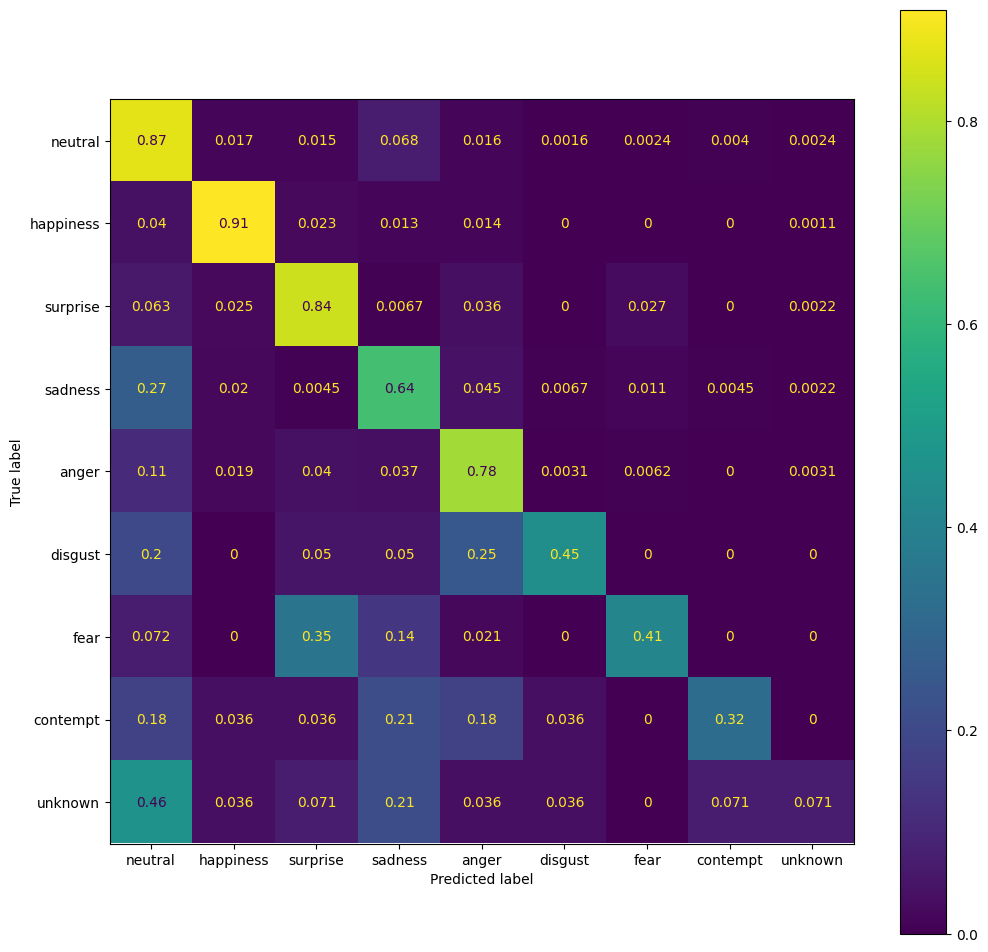

In [17]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

y_true = outputs.label_ids
y_pred = outputs.predictions.argmax(1)

labels = list(label2id.keys())[:-1]
cm = confusion_matrix(y_true, y_pred, normalize='true')
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
fig, ax = plt.subplots(figsize=(12,12))
disp.plot(ax=ax)